In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1) Input Data

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [3]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))

eta = np.transpose(wamos, (1, 2, 0))

Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

Norm = dKx * dKy * dW 

In [5]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 2) Getting Triplets

## 2.1) HP Filter

In [6]:
I_0 = power_Spectrum

w_cut = 0.03 * 2*np.pi
w_cut

0.18849555921538758

In [7]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [8]:
I_1 = np.where(mask[ None, None,:], I_0, 0) 

## 2.2) Energy Threshold

In [9]:
P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [10]:
I_2 = np.where(condition[:, :, None], I_1, 0)

## 2.3) Identify Peaks

In [11]:
def identification(kx, ky, ratio, prominence, distance):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)

        if len(peaks) == 1:
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    wj[kx,ky] = w[peaks[ind]]
                    
    return wj 

In [12]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=3, prominence=0.1*np.max(y), distance=10))

In [13]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

w0 = w0_2D[w0_2D != 0]

nonzero_indices = np.nonzero(w0_2D)
nonzero_indices

(array([51, 51, 53, 54, 54, 54, 54, 55, 55, 56, 56, 56, 57, 58, 58, 59, 59,
        59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63,
        64, 64, 64, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68,
        68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70,
        70, 70, 70, 71, 71, 71, 72, 72, 72, 72, 73, 74, 75, 75, 76, 77, 78],
       dtype=int64),
 array([56, 57, 57, 54, 55, 57, 58, 54, 56, 53, 54, 55, 51, 50, 53, 53, 54,
        78, 49, 51, 53, 50, 52, 53, 46, 73, 80, 47, 49, 53, 69, 73, 74, 76,
        70, 72, 73, 72, 73, 54, 67, 72, 74, 67, 68, 69, 73, 74, 49, 53, 54,
        68, 69, 70, 72, 73, 80, 48, 54, 67, 68, 69, 74, 45, 47, 54, 67, 68,
        73, 75, 76, 49, 67, 74, 50, 65, 67, 73, 49, 48, 50, 80, 76, 75, 52],
       dtype=int64))

In [14]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [15]:
%matplotlib widget

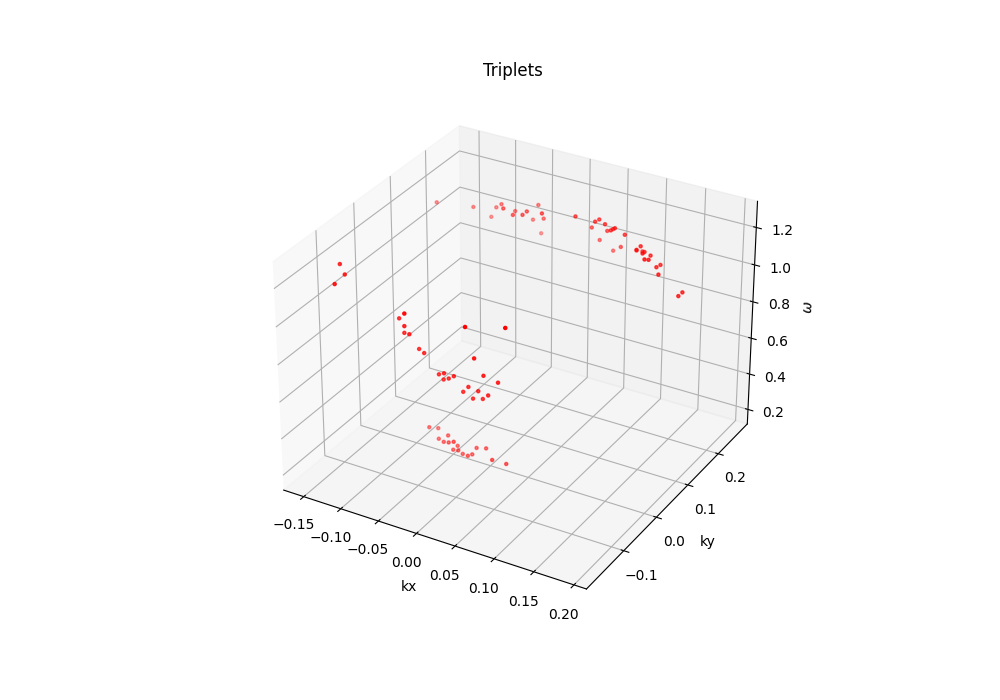

In [16]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Triplets")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

# show plot
plt.show()

## 2.4) Remove Low Wavenumbers

In [17]:
cond_high_k = (np.abs(-ky_trip) > 0.06)
# removing low wavenumbers

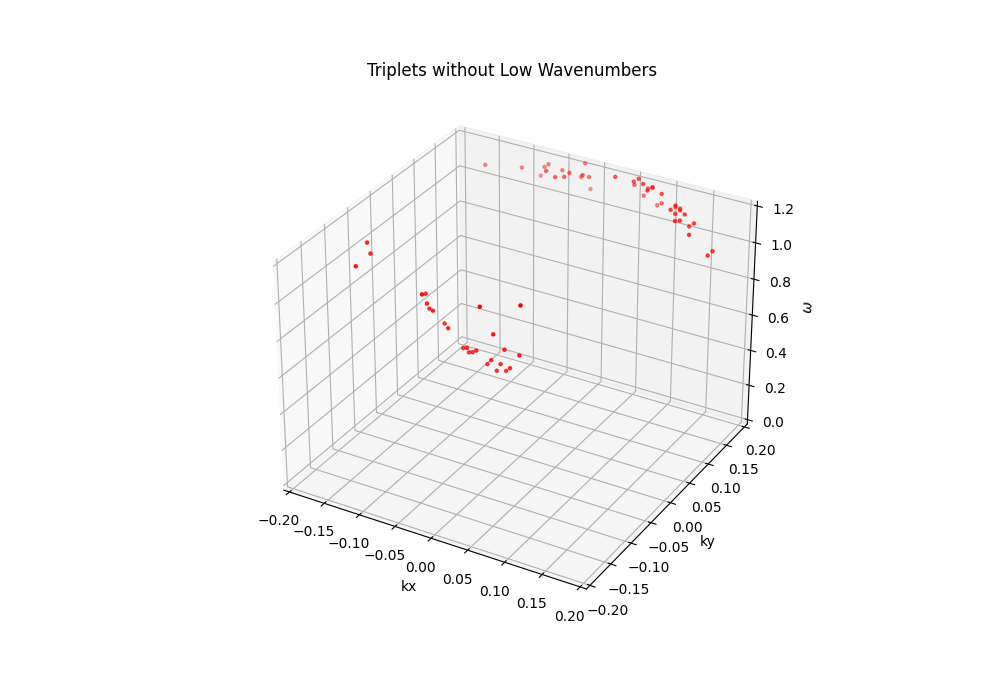

In [18]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k], color = "red", s = 5)
plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.5) Only Consider Aliased Data

In [19]:
all_triplets = (-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k])

In [20]:
cond_alias = (all_triplets[1] > 0)
# Only gives the aliased data

cond_nonalias = (all_triplets[1] < 0)
# Non aliased data

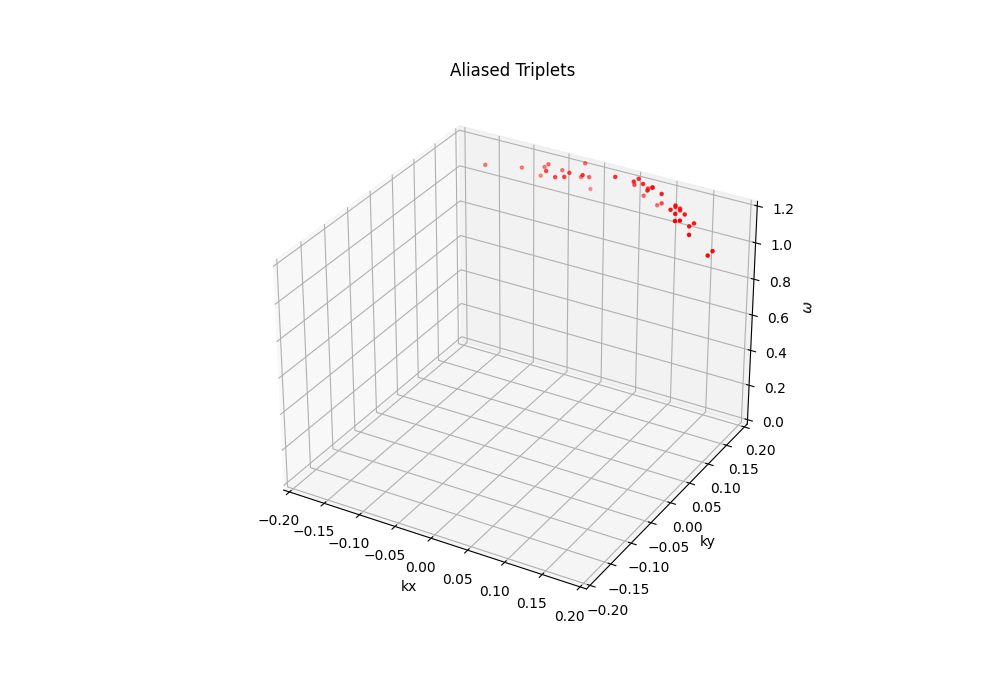

In [21]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D( all_triplets[0][cond_alias],  all_triplets[1][cond_alias],  all_triplets[2][cond_alias], color = "red", s = 5)
plt.title("Aliased Triplets")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.6) Translate Aliased Triplets Across

In [22]:
aliased_triplets = (all_triplets[0][cond_alias],  all_triplets[1][cond_alias],  all_triplets[2][cond_alias])

In [23]:
translated_alias_trip = (all_triplets[0][cond_alias],  all_triplets[1][cond_alias] - 
                         2*np.max(np.abs(all_triplets[1][cond_nonalias])),  
                         all_triplets[2][cond_alias])

# Translated by highest values

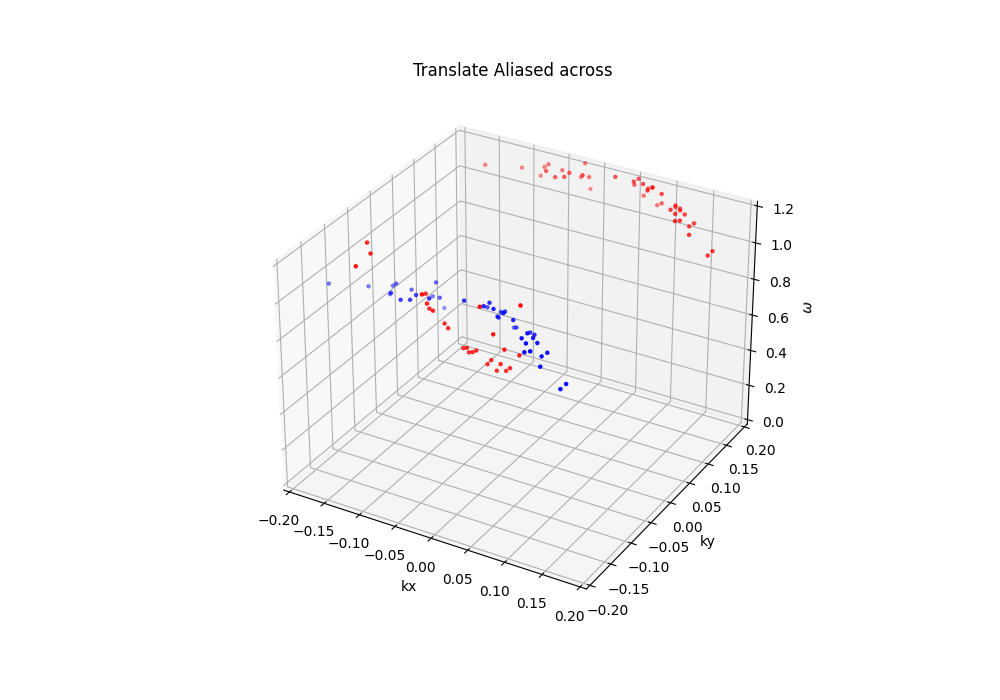

In [24]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D( translated_alias_trip[0],  translated_alias_trip[1],  translated_alias_trip[2], color = "blue", s = 5)

ax.scatter3D(all_triplets[0], all_triplets[1], all_triplets[2], color = "red", s = 5)
plt.title("Translate Aliased across")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.7) Reflection through y direction

In [25]:
# Reflection through y = -0.17
reflection_plane = -np.max(np.abs(all_triplets[1][cond_nonalias]))
reflected_point_y = (translated_alias_trip[0], 2 * reflection_plane - translated_alias_trip[1], translated_alias_trip[2])

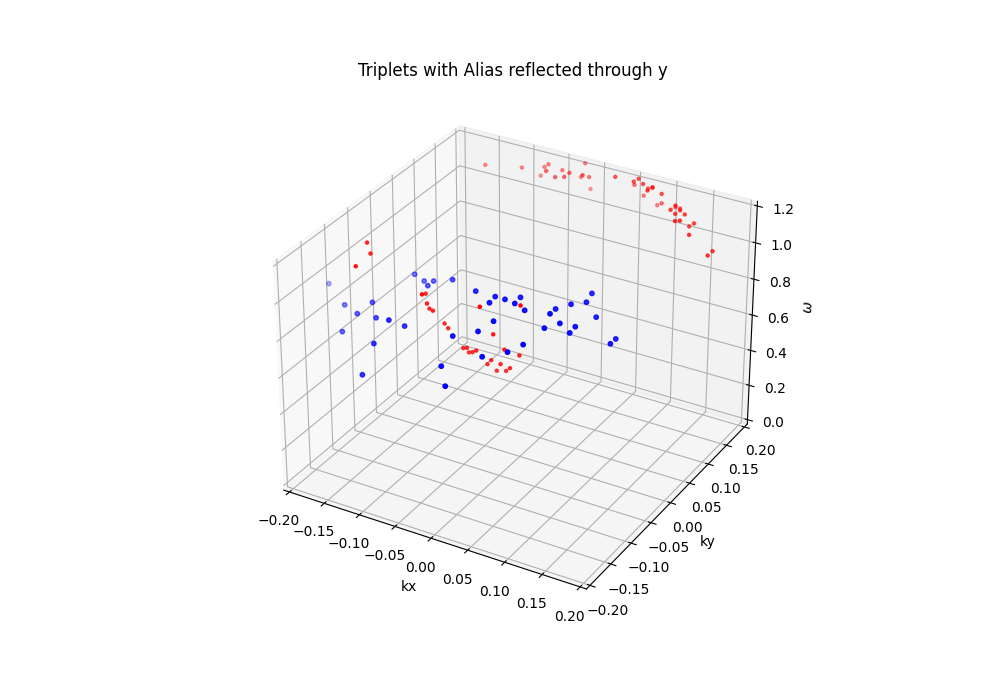

In [26]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_triplets[0], all_triplets[1], all_triplets[2], color = "red", s = 5)

ax.scatter3D(reflected_point_y[0], reflected_point_y[1], reflected_point_y[2], color = "blue", s = 10)

plt.title("Triplets with Alias reflected through y")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.8) Reflection through z direction

In [27]:
# Reflection through z = 1.2
reflection_plane_z = np.max(np.abs(all_triplets[2][cond_nonalias]))
reflected_point_z = (reflected_point_y[0], reflected_point_y[1], 2 * reflection_plane_z - reflected_point_y[2])

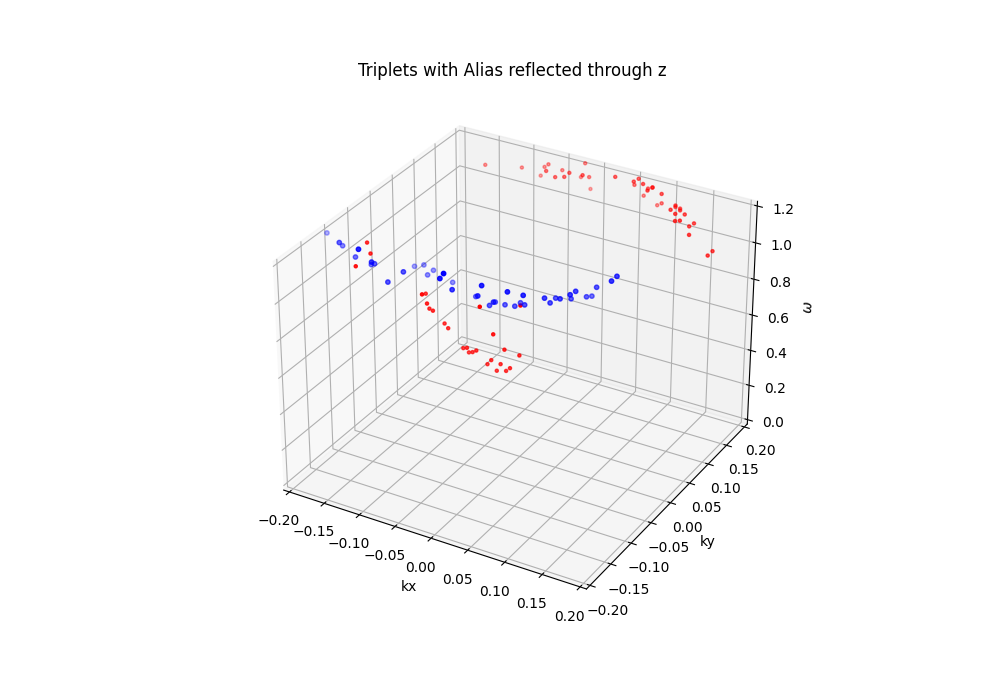

In [28]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_triplets[0], all_triplets[1], all_triplets[2], color = "red", s = 5)

ax.scatter3D(reflected_point_z[0], reflected_point_z[1], reflected_point_z[2], color = "blue", s = 10)

plt.title("Triplets with Alias reflected through z")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

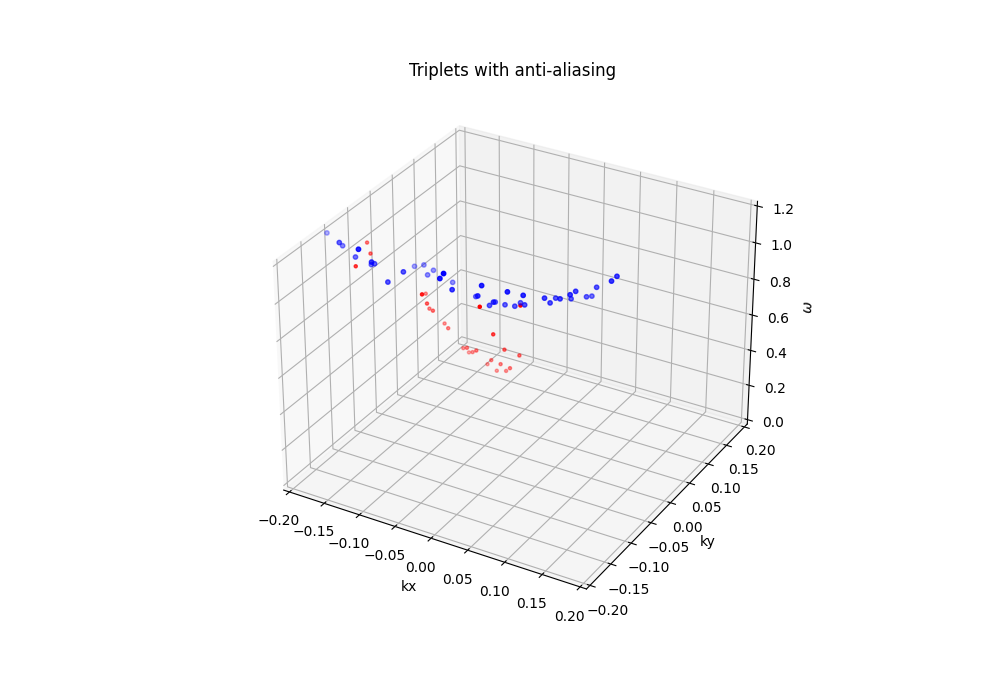

In [29]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_triplets[0][cond_nonalias], all_triplets[1][cond_nonalias], all_triplets[2][cond_nonalias], color = "red", s = 5)

ax.scatter3D(reflected_point_z[0], reflected_point_z[1], reflected_point_z[2], color = "blue", s = 10)

plt.title("Triplets with anti-aliasing")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.9) Fully Anti-aliased Data

In [30]:
kx_trip = np.concatenate((all_triplets[0][cond_nonalias], reflected_point_z[0]))
ky_trip = np.concatenate((all_triplets[1][cond_nonalias], reflected_point_z[1]))
w_trip = np.concatenate((all_triplets[2][cond_nonalias], reflected_point_z[2]))

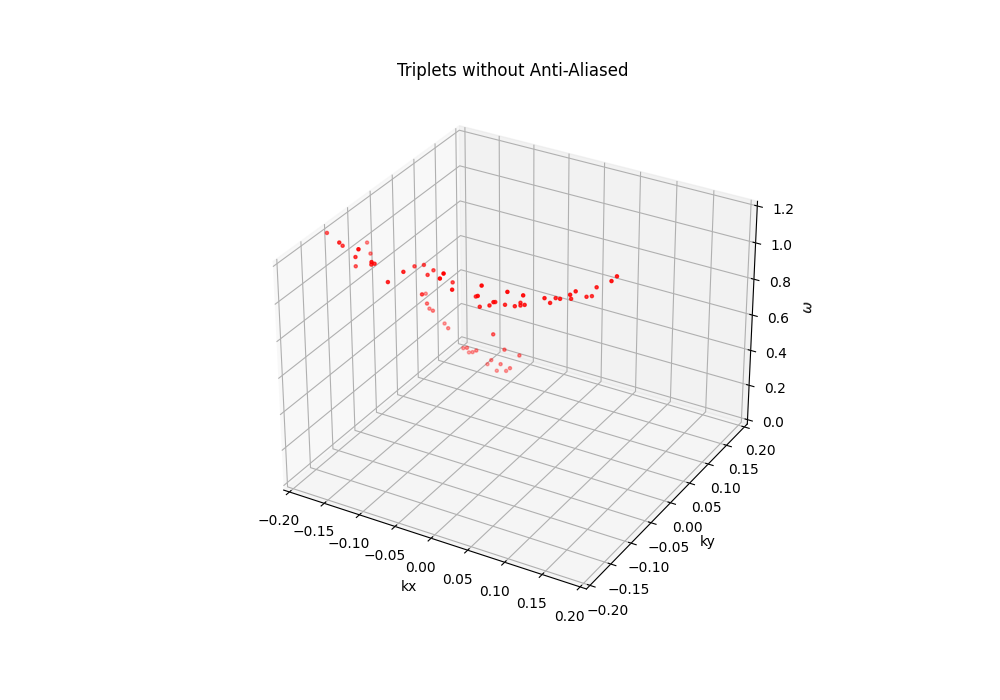

In [31]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(kx_trip, ky_trip, w_trip, color = "red", s = 5)

plt.title("Triplets without Anti-Aliased")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

# 3) Surface Interpolation

In [90]:
%matplotlib widget

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from numpy import ones, vstack
from numpy.linalg import lstsq
from sklearn.metrics import mean_squared_error

In [92]:
x = np.insert(kx_trip, 0, 0)
y = np.insert(ky_trip, 0, 0)
z = np.insert(w_trip, 0, 0)

# Add point at (0,0,0) to improve interpolation

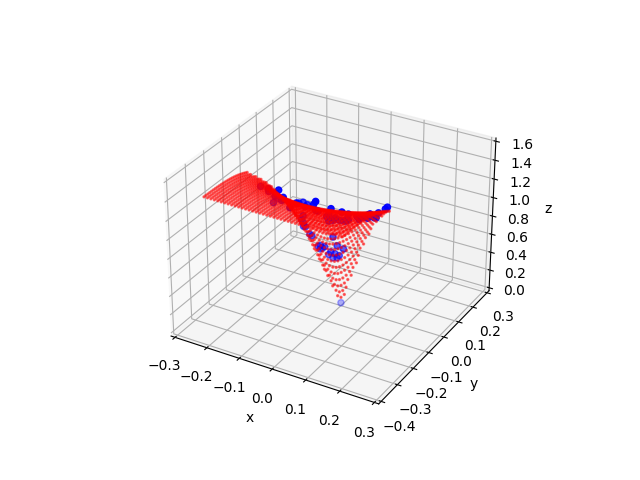

In [93]:
# Find the maximum and minimum x values
# Calculate polar coordinates (theta) using arctangent function
theta_values = np.arctan2(y, x)

i_min = np.where(np.isclose(theta_values, np.min(theta_values)))
i_max = np.where(np.isclose(theta_values,np.max( theta_values[(theta_values != 0)])))
x_max = x[i_max][0]
x_min = x[i_min][0]

# Find the corresponding y values (i.e. y values of those points where x is maximum)
y_max = y[i_max][0]
y_min = y[i_min][0]

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182
def line_coeffs(points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords, ones(len(x_coords))]).T
    # y = a*x + b
    a, b = lstsq(A, y_coords, rcond=None)[0]
    return (a, b)

# Find coefficients of the two lines "limiting" all points left and right across the x-axis in the XY-plane
k1_max, k2_max = line_coeffs([(x_max, y_max), (0, 0)])
k1_min, k2_min = line_coeffs([(x_min, y_min), (0, 0)])

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182
def func(xy, a, b, c, d, e, f):
    x, y = xy
    r = np.sqrt(x**2/b**2 + y**2/c**2 ) +d*x +e*y**2 + f*x**2 
    return a*(1-np.exp(-r))

# Create a grid of points over the surface
x_fill = np.linspace(-0.2, 0.2, 40)
y_fill = np.linspace(-0.4, 0, 40)
X_fill, Y_fill = np.meshgrid(x_fill, y_fill)

# Perform curve fitting 
popt, pcov = curve_fit(func, (x, y), z)

# Evaluate the function at each point on the surface
Z_fill = func((X_fill, Y_fill), *popt)

# Plot the data points and the filled surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue', label='Data Points')

ax.scatter(np.where(X_fill >= (Y_fill - k2_min)/k1_min, np.where(X_fill <= (Y_fill - k2_max)/k1_max, X_fill, np.nan), np.nan), Y_fill, Z_fill, color='red', alpha=0.5, s= 2)

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.4, 0.3])
ax.set_zlim([0, 1.6])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [54]:
predicted_values = func((x, y), *popt)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(z, predicted_values))
rmse

0.04413060698120209

In [55]:
# Find the interpolated points
interpolated_points_x = np.where(X_fill >= (Y_fill - k2_min) / k1_min,
                                  np.where(X_fill <= (Y_fill - k2_max) / k1_max, X_fill, np.nan), np.nan).flatten()
interpolated_points_y = Y_fill.flatten()
interpolated_points_z = Z_fill.flatten()

In [56]:
not_nan_indices = np.where(~np.isnan(interpolated_points_x))

In [57]:
kx_triplets = interpolated_points_x[not_nan_indices]
ky_triplets = interpolated_points_y[not_nan_indices]
w_triplets = interpolated_points_z[not_nan_indices]

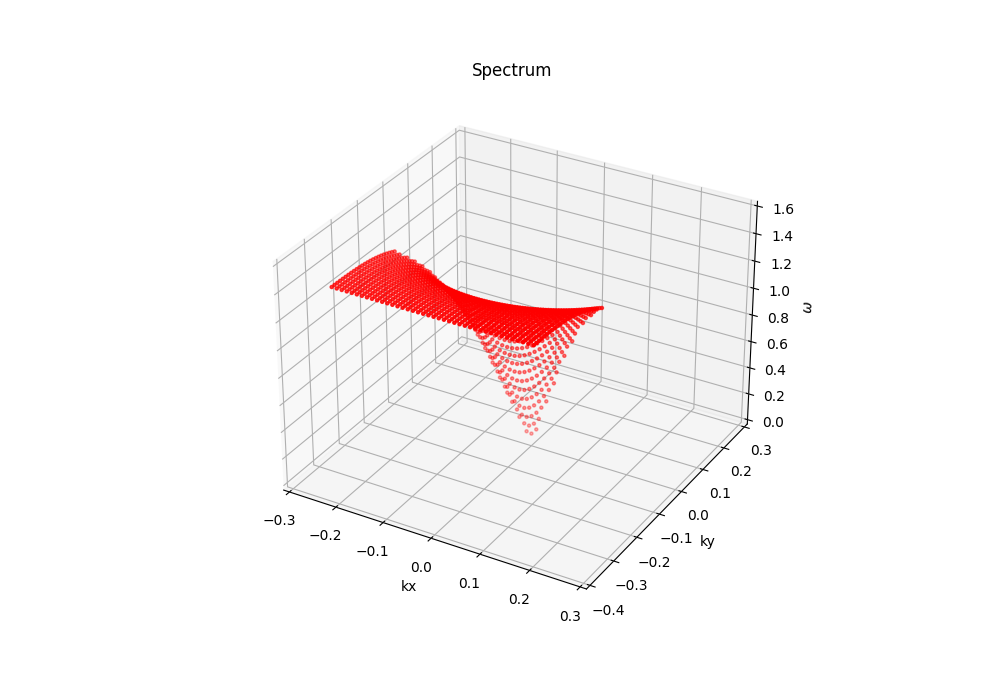

In [58]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(kx_triplets, ky_triplets, w_triplets, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.4, 0.3])
ax.set_zlim([0, 1.6])
 
# show plot
plt.show()

# 4) Perform PCS Method

In [99]:
%matplotlib inline

In [100]:
from scipy.stats import t

In [101]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b)

In [102]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [103]:
#cut_k_array = np.arange(0.001, 0.35, 0.01)
cut_k_array = np.arange(0.05, 0.35, 0.01)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]
    
    k_abs = np.sqrt(kx_triplets**2 + ky_triplets**2)
    theta = np.arctan2(ky_triplets, kx_triplets)
    
    reso = 0.005
    ind = np.where(((k_slice - reso) < k_abs ) & ( k_abs < (k_slice + reso)))
    
    if len(w_triplets[ind]) > 10:
    
        x1 = theta[ind]
        y = ( w_triplets[ind] - np.sqrt(9.81*k_slice) )  / k_slice
    
        # Perform Grubbs test
        x1, y = grubbs_test(x1, y)
    
    
        # initial guess
        pars0 = ( max(y), 1)
        popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
            # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    
    else:
        U_array.append(None)
        Φ_array.append(None)

In [104]:
x_NSP = np.array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
        0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243, 0.32, 0.33, 0.35]).reshape(-1, 1)

y_NSP = np.array([1.53989397, 2.04460628, 4.18043213, 2.97621482, 2.82642339,
       2.98335023, 2.98964836, 2.12218901, 1.42801972, 1.25930683,
       0.71644077, 0.48220866, 0.21165985, 0.24756609, 0.21123179,
       0.57344999, 0.49362762, 0.20282767, 0.50321186, 0.50347165,
       0.74259408, 0.48493783, 0.81785588, 0.54543666, 0.53218838])

(0.05, 0.35)

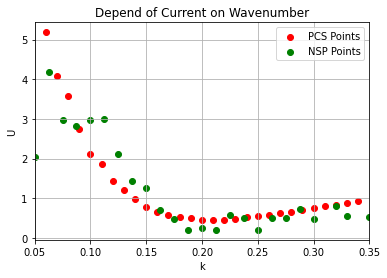

In [105]:
plt.scatter(cut_k_array, U_array, color = 'red', label = 'PCS Points')
plt.scatter(x_NSP, y_NSP, color = 'green', label = 'NSP Points')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
plt.xlim(np.min(cut_k_array), np.max(x_NSP))

(-3.141592653589793, 3.141592653589793)

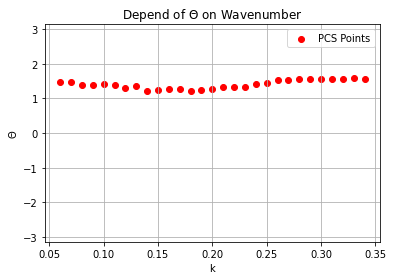

In [106]:
plt.scatter(cut_k_array,Φ_array, color = 'red', label = 'PCS Points')

plt.xlabel("k")
plt.ylabel("$\Theta$")
plt.title("Depend of $\Theta$ on Wavenumber")
plt.grid(True)
plt.legend()
plt.ylim(-np.pi,np.pi)

# 5) Invert Current Profile

## 5.1) EDM Method

In [107]:
# New arrays that are only numbers
indices = []

U_array_int = []
for index, item in enumerate(U_array):
    if isinstance(item, (int, float)) or (item is not None and str(item).replace('.', '', 1).isdigit()):
        U_array_int.append(item)
        indices.append(index)
        
Φ_array_int = []
for item in Φ_array:
    if isinstance(item, (int, float)) or (item is not None and str(item).replace('.', '', 1).isdigit()):
        Φ_array_int.append(item)
        
cut_k_array_int = []
cut_k_array_int = cut_k_array[indices]

In [108]:
Ux = U_array_int*np.cos(Φ_array_int)
Uy = U_array_int*np.sin(Φ_array_int)

wavenumbers = cut_k_array_int

## 5.1.1) Linear Fit

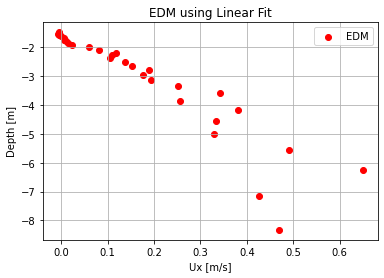

In [109]:
plt.scatter(Ux , -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM using Linear Fit")
plt.xlabel("Ux [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

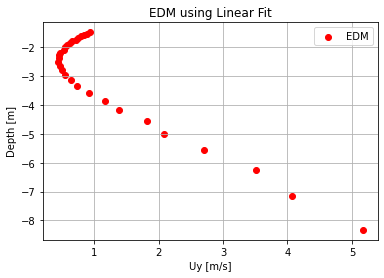

In [110]:
plt.scatter(Uy , -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM using Linear Fit")
plt.xlabel("Uy [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

## 5.1.2) Logarithmic 

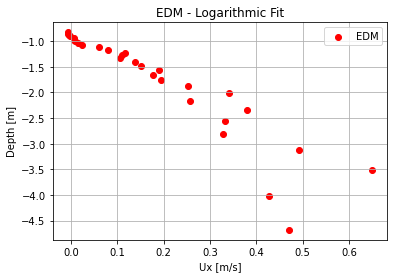

In [111]:
plt.scatter(Ux, -1/(3.56*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM - Logarithmic Fit")
plt.xlabel("Ux [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

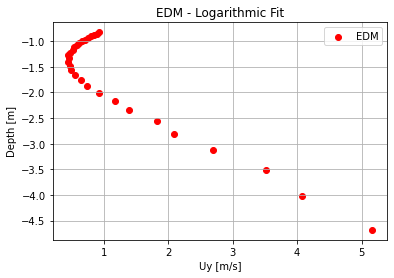

In [112]:
plt.scatter(Uy, -1/(3.56*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM - Logarithmic Fit")
plt.xlabel("Uy [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

## 5.2) PEDM Method

In [73]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial

In [74]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1
                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

## 5.2.1) Actual Points

In [75]:
pPEDM, pEDM, eps_PEDM, eps_EDM, verbose = pedm(wavenumbers, U_array_int)

In [76]:
z = np.linspace(-20, 0, 100)

In [77]:
U_fun = lambda z: np.polyval(pPEDM, z)

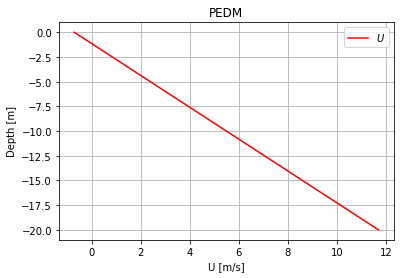

In [78]:
plt.plot(U_fun(z), z, label="$U$", color = 'red')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

## 5.2.2) Weighted Least Squares Fit

In [79]:
filtered_x = cut_k_array_int
filtered_y = U_array_int

In [80]:
filtered_x = np.insert(filtered_x, 0, 1e-8)
filtered_y = np.insert(filtered_y, 0, 1e-8)

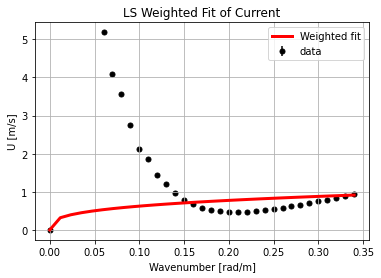

In [116]:
def fpow(x, a, b):
    return a * x**b 

def custom_weights(x):
    weights = np.ones_like(x)  # default weight for all points
    weights[(0 < x) & (x <= 0.2)] = 0.2  # medium error for 0 < x <= 0.2
    weights[x > 0.2] = 0.1  # low error for x > 0.15
    weights[np.isclose(x, 0, atol=1e-8)] = 0.001  # very low error for x = 0
    return weights

# initial guess
pars0 = (0.4, 0.4)

# perform fitting with custom weights
popt, pcov = curve_fit(fpow, filtered_x, filtered_y, absolute_sigma=True, p0=pars0, sigma=custom_weights(filtered_x), maxfev=5000)

# parameters
a_opt = popt[0]
b_opt = popt[1]

# plot data
plt.errorbar(filtered_x, filtered_y, yerr=0, fmt =".", color='black', label ='data', zorder=1, markersize=10)

# creating x interval to include in y fit
x_interval = np.linspace(0, max(filtered_x), len(filtered_x))
y_fit = fpow( x_interval , *popt)
plt.plot( x_interval, y_fit, color = "red", label = "Weighted fit", zorder=2 , linewidth=3)

plt.grid(True)
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS Weighted Fit of Current")
plt.legend()
plt.show()

In [117]:
pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])

<ipython-input-117-f535d120b704>:1: RankWarning: Polyfit may be poorly conditioned
  pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])
<ipython-input-117-f535d120b704>:1: RankWarning: Polyfit may be poorly conditioned
  pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])
<ipython-input-117-f535d120b704>:1: RankWarning: Polyfit may be poorly conditioned
  pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])
<ipython-input-117-f535d120b704>:1: RankWarning: Polyfit may be poorly conditioned
  pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])
<ipython-input-117-f535d120b704>:1: RankWarning: Polyfit may be poorly conditioned
  pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])
<ipython-input-117-f535d120b704>:1: RankWarning: Polyfit may be poorly conditioned
  pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])
<ipython-input-1

In [118]:
z = np.linspace(-40, 0, 100)

In [119]:
U1_fun = lambda z: np.polyval(pPEDM1, z)

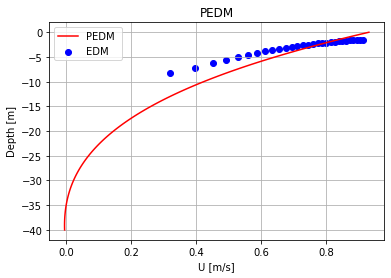

In [120]:
plt.plot(U1_fun(z), z, label="PEDM ", color = 'red')

plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM', color = 'blue')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

#plt.xlim(-0.01, 0.7)

# 6) Dispersion Shell

In [121]:
%matplotlib widget

In [122]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [ 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

In [123]:
psi0 = np.sum(Φ_array_int)/len(Φ_array_int)
psi0

1.4086125311512991

(0.0, 1.6)

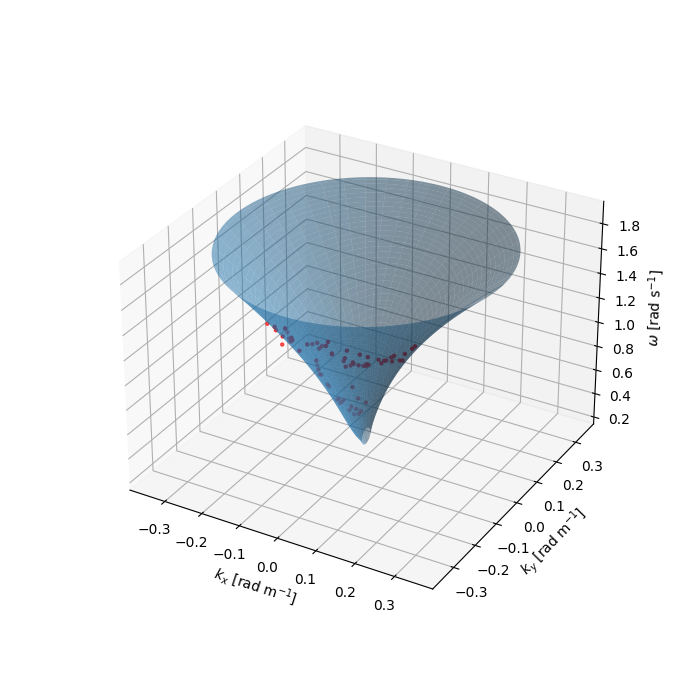

In [124]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=1000, z = z, U = U_fun(z), psi = psi0)

axes.scatter3D(kx_trip, ky_trip, w_trip, color = "red", s = 5)

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.4, 0.3])
ax.set_zlim([0, 1.6])